# Configurações

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.7 MB/s eta 0:00:00


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=55243a5b53392cc00b52ddd3716051dd6edc38826f5793b2481aa8154748e6e9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from lime import lime_tabular

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc

import xgboost as xgb
import optuna


# Importa base de dados

In [ ]:
df = pd.read_csv('insuranceFraud.csv')

In [ ]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [ ]:
df.isna().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_state,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0


In [ ]:
df.shape

(1000, 39)

# Público



*   Nível do modelo: Apólice
*   Datas de referência: Jan.1990 a Fev.2015



**Checa duplicidade**

In [ ]:
checkdup = df.groupby('policy_number')['months_as_customer'].count().reset_index()


In [ ]:
checkdup[checkdup['months_as_customer']>1] #sem duplicidade por apólice

,policy_number,months_as_customer


**Verifica meses**

In [ ]:
df['policy_bind_date_d'] = pd.to_datetime(df['policy_bind_date'])

In [ ]:
df['policy_bind_date_d'].agg({'min','max'})

,policy_bind_date_d
max,2015-02-22
min,1990-01-08


**Análise descritiva**

In [ ]:
df['policy_bind_year'] = df['policy_bind_date_d'].dt.to_period('Y').astype(str)

In [ ]:
volumetria = df.groupby('policy_bind_year')['policy_number'].count().reset_index()

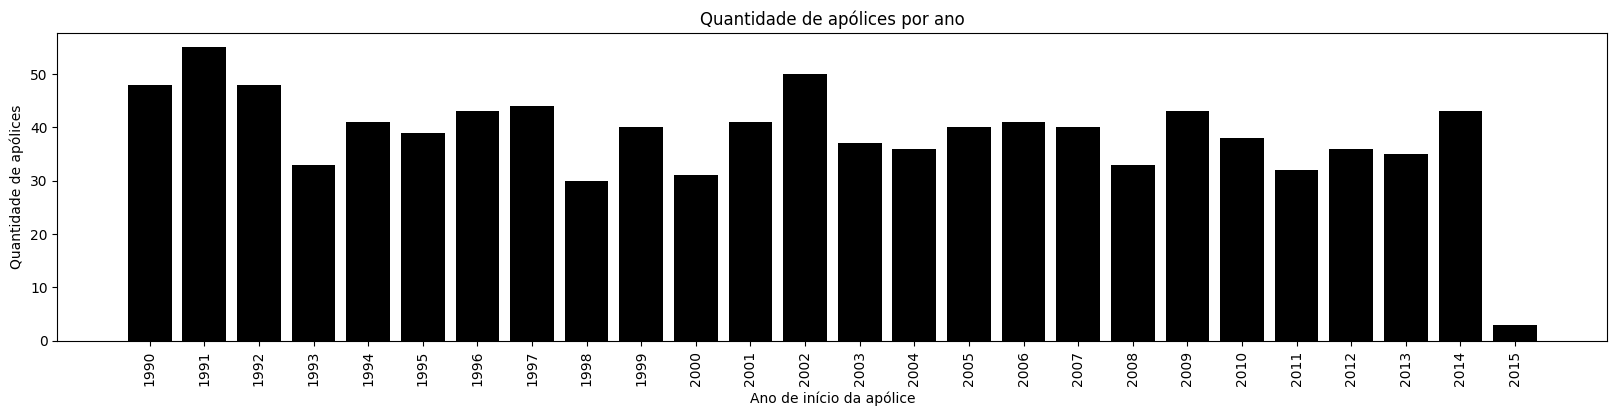

In [ ]:
plt.figure(figsize=(20,4))
plt.bar(volumetria['policy_bind_year'],volumetria['policy_number'],color='black')
plt.title('Quantidade de apólices por ano')
plt.xlabel('Ano de início da apólice')
plt.ylabel('Quantidade de apólices')
plt.xticks(rotation=90,va='top')
plt.show()

# Variável Resposta

In [ ]:
df['flag_fraud'] = (df['fraud_reported'] == 'Y').astype(int)


In [ ]:
df['flag_fraud'].value_counts(normalize=True)

,proportion
flag_fraud,
0,0.753
1,0.247


In [ ]:
perc_target = pd.crosstab(df['policy_bind_year'],df['flag_fraud'],normalize='index').reset_index()

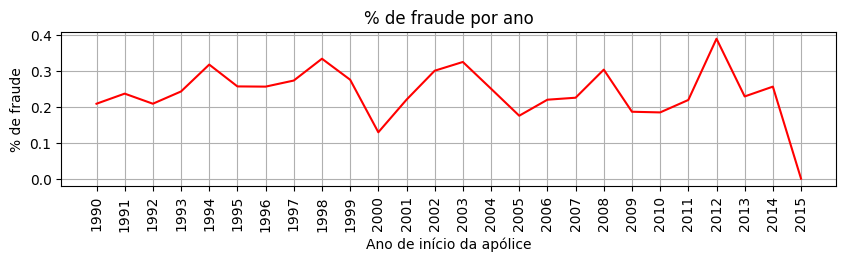

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(perc_target['policy_bind_year'],perc_target[1],color='red')
plt.title('% de fraude por ano')
plt.xlabel('Ano de início da apólice')
plt.ylabel('% de fraude')
plt.xticks(rotation=90,va='top')
plt.grid(True)
plt.show()

# Features

Features:

1.	months_as_customer: It denotes the number of months for which the customer is associated with the insurance company.
2.	age: continuous. It denotes the age of the person.
3.	policy_number: The policy number.
4.	policy_bind_date: Start date of the policy.
5.	policy_state: The state where the policy is registered.
6.	policy_csl-combined single limits. How much of the bodily injury will be covered from the total damage.
https://www.berkshireinsuranceservices.com/arecombinedsinglelimitsbetter  
7.	policy_deductable: The amount paid out of pocket by the policy-holder before an insurance provider will pay any expenses.
8.	policy_annual_premium: The yearly premium for the policy.
9.	umbrella_limit: An umbrella insurance policy is extra liability insurance coverage that goes beyond the limits of the insured's homeowners, auto or watercraft insurance. It provides an additional layer of security to those who are at risk of being sued for damages to other people's property or injuries caused to others in an accident.
10.	insured_zip: The zip code where the policy is registered.
11.	insured_sex: It denotes the person's gender.
12.	insured_education_level: The highest educational qualification of the policy-holder.
13.	insured_occupation: The occupation of the policy-holder.
14.	insured_hobbies: The hobbies of the policy-holder.
15.	insured_relationship: Dependents on the policy-holder.
16.	capital-gain: It denotes the monitory gains by the person.
17.	capital-loss: It denotes the monitory loss by the person.
18.	incident_date: The date when the incident happened.
19.	incident_type: The type of the incident.
20.	collision_type: The type of collision that took place.
21.	incident_severity: The severity of the incident.
22.	authorities_contacted: Which authority was contacted.
23.	incident_state: The state in which the incident took place.
24.	incident_city: The city in which the incident took place.
25.	incident_location: The street in which the incident took place.
26.	incident_hour_of_the_day: The time of the day when the incident took place.
27.	property_damage: If any property damage was done.
28.	bodily_injuries: Number of bodily injuries.
29.	Witnesses: Number of witnesses present.
30.	police_report_available: Is the police report available.
31.	total_claim_amount: Total amount claimed by the customer.
32.	injury_claim: Amount claimed for injury
33.	property_claim: Amount claimed for property damage.
34.	vehicle_claim: Amount claimed for vehicle damage.
35.	auto_make: The manufacturer of the vehicle
36.	auto_model: The model of the vehicle.
37.	auto_year: The year of manufacture of the vehicle.


**Missing**

In [ ]:
df.isna().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_state,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0


In [ ]:
df2 = df.copy()
df2['authorities_contacted'] = df2['authorities_contacted'].fillna('Other')

**One hot encode**

In [ ]:
df3 = pd.get_dummies(df2, columns=['policy_state','policy_csl','insured_sex','insured_education_level','insured_occupation','insured_hobbies','insured_relationship','incident_type','collision_type','incident_severity'
,'authorities_contacted','incident_state','property_damage','police_report_available','auto_make'], drop_first=True)

In [ ]:
#algumas variáveis não fazem sentido para modelagem:
df3 = df3.drop(['policy_bind_date','incident_date','fraud_reported','policy_bind_date_d','policy_bind_year'],axis=1)

#algumas variáveis categórias tem alta dimensionalidade, e podem causar problemas na modelagem, uma vez que se amostra uma parte das variáveis a cada iteração,
#e muitas flags podem causar viés na aleatoridade
df3 = df3.drop(['incident_city','incident_location','insured_zip','auto_model'],axis=1)

**Análise descritiva**

<ipython-input-22-0e180e9cb943>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


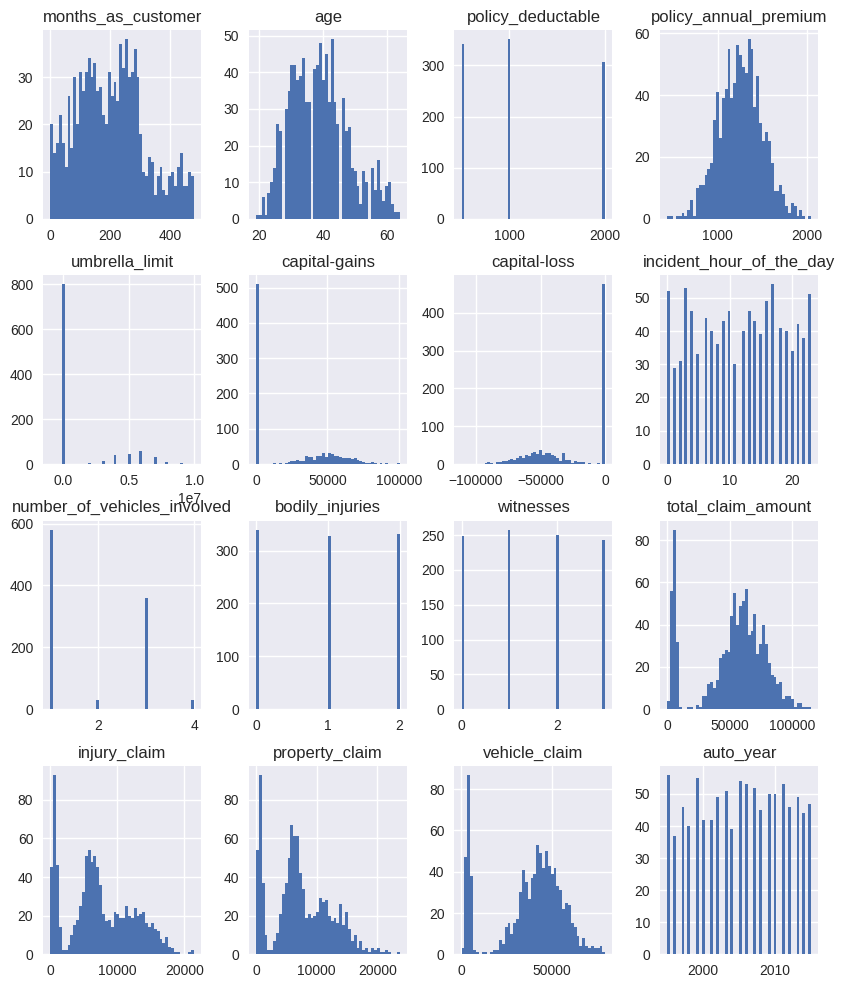

In [ ]:
#verifica todas as variáveis, menos ID e target
plt.style.use('seaborn')
df3.drop(['policy_number','flag_fraud'],axis=1).hist(bins=50,figsize=(10,12))
plt.show()

**Correlação**

<Axes: >

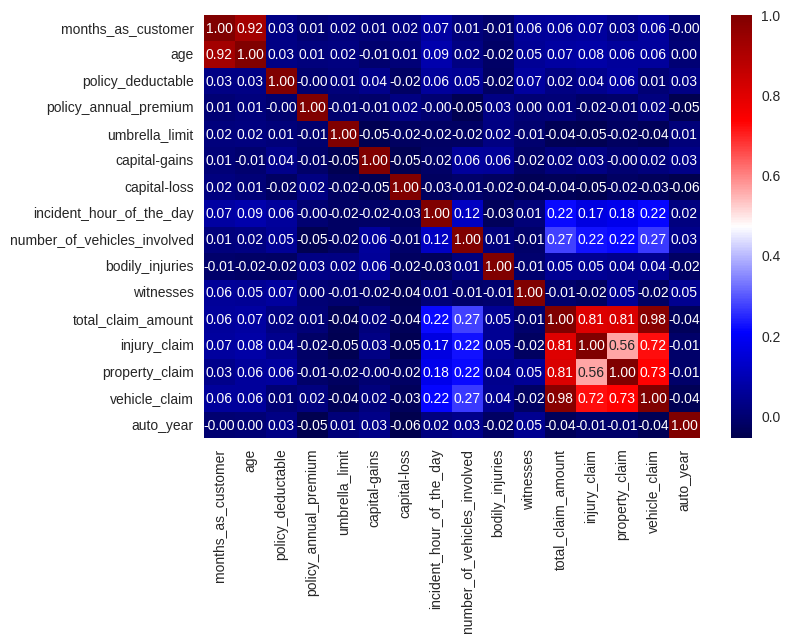

In [ ]:
#somente entre features não dummy
non_dummies = df3.select_dtypes(exclude=['bool'])
sns.heatmap(non_dummies.drop(['policy_number','flag_fraud'],axis=1).corr(), cmap='seismic', annot=True, fmt=".2f")

Removendo as variáveis *total_claim_amount* e *months_as_customer*, todas as correlações ficam abaixo de 75%.

# Model training

In [ ]:
X = df3.drop(['policy_number','flag_fraud','total_claim_amount','months_as_customer'],axis=1)
y = df3['flag_fraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

## Gradient Boosting

In [ ]:
model = GradientBoostingClassifier()
#model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8)

model.fit(X_train, y_train) # Treinar o modelo

GradientBoostingClassifier()

In [ ]:
#Avalia métrica na base de treino e teste
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Acurácia treino:", accuracy_score(y_train, y_pred_train))
print("Acurácia teste:", accuracy_score(y_test, y_pred_test))

Acurácia treino: 0.9728571428571429
Acurácia teste: 0.8066666666666666


***A acurácia no treino é alta, mas há overfitting.***

## + Cross validation

In [ ]:
# Não há como colocar o cross validation "dentro" do gradient boosting diretamente.
# Neste código a possibilidade é chamar o cross validation, mas ele gera k modelos, e retorna a métrica dos cinco separadas.
# Não há UM modelo final.

model_cv = GradientBoostingClassifier()

# Perform 5-fold cross-validation (default metric = accuracy)
scores = cross_val_score(model_cv, X, y, cv=5)

# Print the accuracy for each fold
print("Cross-validation scores accuracy: ", scores)

# Print the average accuracy
print("Average accuracy: ", scores.mean())

KeyboardInterrupt: 

***O overfitting é mitigado, porém não há um modelo único para seguir.***

## + Cross validation + Hyperparameter search (GridSearch)

In [ ]:
#Para incorporar o cross-validation no treinamento do modelo e ter um modelo final, podemos colocá-lo no ajuste de hiperparâmetros,
#de forma que o cross-validation é usado para ajustar os hiperparâmetros durante o treinamento, e depois o modelo final é ajustado nos
#dados de treinamento, com os melhores hiperparâmetros encontrados.

#---GridSearchCV
#É necessário passar todos os valores exatos que deseja testar para cada hiperparâmetro, e o algoritmo testa todas as combinações
#possíveis dos hiperparâmetros fornecidos.

model_cv_hyper = GradientBoostingClassifier()

# Definir o grid de hiperparâmetros para busca
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Configurar o GridSearchCV com cross-validation (cv=k)
grid_search = GridSearchCV(estimator=model_cv_hyper, param_grid=param_grid, cv=10, scoring='accuracy')

# Fazer o ajuste com os dados
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Modelo final já treinado com os melhores hiperparâmetros
best_model_model_cv_hyper = grid_search.best_estimator_


In [ ]:
#Avalia métrica na base de treino e teste
y_pred_train2 = best_model_model_cv_hyper.predict(X_train)
y_pred_test2 = best_model_model_cv_hyper.predict(X_test)

print("Acurácia do melhor modelo: ", grid_search.best_score_) #durante o treinamento, nas iterações com CV (média das k métricas da melhor combinação: k-1 modelos + fold de validação)
print("Acurácia treino:", accuracy_score(y_train, y_pred_train2)) #para o conjunto de treinamento completo
print("Acurácia teste:", accuracy_score(y_test, y_pred_test2))

***Com o novo treinamento, overfitting diminuiu***

## + Cross validation + Hyperparameter search (RandomSearch)

In [ ]:
#---RandomizedSearchCV
#É necessário passar uma lista ou uma distribuição de valores para cada hiperparâmetro, e o algoritmo seleciona aleatoriamente
#combinações desses valores, mas sem nenhuma otimização.


model_cv_hyper_rand = GradientBoostingClassifier()

# Definir o grid de hiperparâmetros para busca
param_dist = {
    'n_estimators': np.arange(50, 201, 50),  # Valores de 50 a 200 em passos de 50
    'learning_rate': np.linspace(0.01, 0.2, 10),  # Taxa de aprendizado de 0.01 a 0.2
    'max_depth': np.arange(3, 6),  # Profundidade de 3 a 5
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Subamostragem
    'min_samples_split': np.arange(2, 11, 2),  # Mínimo de amostras para dividir um nó
}

# Configurar o GridSearchCV com cross-validation (cv=k)
random_search = RandomizedSearchCV(estimator=model_cv_hyper_rand, param_distributions=param_dist, n_iter=20, cv=10, scoring='accuracy', n_jobs=-1, random_state=42)

# Fazer o ajuste com os dados
random_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros: ", random_search.best_params_)

# Modelo final já treinado com os melhores hiperparâmetros
best_model_model_cv_hyper_rand = random_search.best_estimator_


In [ ]:
#Avalia métrica na base de treino e teste
y_pred_train3 = best_model_model_cv_hyper_rand.predict(X_train)
y_pred_test3 = best_model_model_cv_hyper_rand.predict(X_test)

print("Acurácia do melhor modelo: ", random_search.best_score_) #durante o treinamento, nas iterações com CV (média dos k-1 modelos da melhor iteração)
print("Acurácia treino:", accuracy_score(y_train, y_pred_train3)) #para o conjunto de treinamento completo
print("Acurácia teste:", accuracy_score(y_test, y_pred_test3))

***Apesar do resultado do CV e do teste serem similares, a alta acurácia nos dados de treinamento completo indica um forte overfitting.***

## + Hyperparameter tuning (Optuna)

In [ ]:
# Definir a função objetiva para otimizar
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 5)

    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)  #Fazer previsões e calcular a acurácia para ser otimizada
    accuracy_train = accuracy_score(y_train, y_pred_train)

    return accuracy_train

# Otimização com Optuna
study = optuna.create_study(direction='maximize') #Deseja-se otimizar a acurácia
study.optimize(objective, n_trials=100)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", study.best_params)

# Cria o modelo com os parâmetros otimizados encontrados no Optuna
best_model_optuna = GradientBoostingClassifier(**study.best_params)
best_model_optuna.fit(X_train, y_train)

In [ ]:
#Avalia métrica na base de treino e teste
y_pred_train4 = best_model_optuna.predict(X_train)
y_pred_test4 = best_model_optuna.predict(X_test)

print("Acurácia do melhor modelo: ", study.best_value) #durante o treinamento, nas iterações com CV (média dos k-1 modelos da melhor iteração)
print("Acurácia treino:", accuracy_score(y_train, y_pred_train4)) #para o conjunto de treinamento completo
print("Acurácia teste:", accuracy_score(y_test, y_pred_test4))

***Novamente há overfitting***

## + Hyperparameter Tuning (Optuna) + Cross Validation

com seed para replicabilidade

In [ ]:
# Definir a função objetiva para otimizar
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    #min_samples_split = trial.suggest_int('min_samples_split', 10, 100)

    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth #, min_samples_split=min_samples_split)
                                      ,random_state = 22)

    #Para usar cross-validation (validação cruzada), é preciso especificar na função objetiva.
    accuracy_train = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy').mean()

    return accuracy_train

# Otimização com Optuna
sampler = optuna.samplers.RandomSampler(seed=22)  # Definir um seed para replicabilidade
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", study.best_params)

# Cria o modelo com os parâmetros otimizados encontrados no Optuna
best_model_optuna_cv = GradientBoostingClassifier(**study.best_params)
best_model_optuna_cv.fit(X_train, y_train)

[I 2024-10-06 10:13:23,816] A new study created in memory with name: no-name-f81b612e-186b-4025-9530-1a094aaef6c5
[I 2024-10-06 10:13:29,711] Trial 0 finished with value: 0.8028571428571428 and parameters: {'n_estimators': 81, 'learning_rate': 0.10151940173503951, 'max_depth': 4}. Best is trial 0 with value: 0.8028571428571428.
[I 2024-10-06 10:13:40,164] Trial 1 finished with value: 0.7985714285714286 and parameters: {'n_estimators': 179, 'learning_rate': 0.04252069518621793, 'max_depth': 4}. Best is trial 0 with value: 0.8028571428571428.
[I 2024-10-06 10:13:48,190] Trial 2 finished with value: 0.8057142857142857 and parameters: {'n_estimators': 90, 'learning_rate': 0.14129785658542326, 'max_depth': 3}. Best is trial 2 with value: 0.8057142857142857.
[I 2024-10-06 10:14:07,881] Trial 3 finished with value: 0.7985714285714286 and parameters: {'n_estimators': 172, 'learning_rate': 0.012000106120060604, 'max_depth': 4}. Best is trial 2 with value: 0.8057142857142857.
[I 2024-10-06 10:14

Melhores hiperparâmetros:  {'n_estimators': 116, 'learning_rate': 0.028218075884427818, 'max_depth': 3}


GradientBoostingClassifier(learning_rate=0.028218075884427818, n_estimators=116)

In [ ]:
#Avalia métrica na base de treino e teste
y_pred_train5 = best_model_optuna_cv.predict(X_train)
y_pred_test5 = best_model_optuna_cv.predict(X_test)

print("Acurácia do melhor modelo: ", study.best_value) #durante o treinamento, nas iterações com CV (média dos k-1 modelos da melhor iteração)
print("Acurácia treino:", accuracy_score(y_train, y_pred_train5)) #para o conjunto de treinamento completo
print("Acurácia teste:", accuracy_score(y_test, y_pred_test5))

Acurácia do melhor modelo:  0.8142857142857143
Acurácia treino: 0.89
Acurácia teste: 0.8


***Para cv = 5:***  

Acurácia do melhor modelo: 0.821  
Acurácia treino: 0.954  
Acurácia teste: 0.823

A diferença entre a acurácia no treino e no teste pode indicar overfitting leve, mas como a acurácia no teste é próxima da validação cruzada, o modelo ainda está generalizando bem.

***Para cv = 10:***    

Acurácia do melhor modelo: 0.816  
Acurácia treino: 0.890   
Acurácia teste: 0.800

O overfitting foi mais mitigado.

# Testes de qualidade

## Métricas

**Confunsion Matrix**

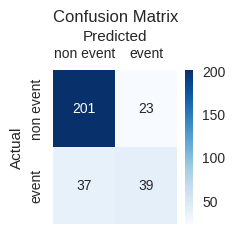

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test5)

plt.figure(figsize=(2,2))

#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"],
#            yticklabels=["Actual Negative", "Actual Positive"])
cm_plot = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non event", "event"],
            yticklabels=["non event", "event"])
cm_plot.xaxis.set_ticks_position('top')
cm_plot.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Métricas baseadas em threshold**

In [ ]:
#Acurácia: de todos, quantos estão classificados certos?
print('Acurácia: ', (201+39)/(201+39+23+37))

#FPR: de todos os não eventos, quantos estão classificados errados?
print('FPR (type I error): ', (23)/(201+23))

#FPR: de todos os eventos, quantos estão classificados errados?
print('FNR (type II error): ', (37)/(37+39))

#Recall: de todos os eventos, quantos estão classificados certos?
recall = (39)/(37+39)
print('Recall: ', recall)

#Precision: de todos classificados como evento, quantos são realmente eventos?
precision = (39)/(23+39)
print('Precision: ', precision)

#F1 Score: balanço entre precison e recall
print('F1-Sore: ', 2* ((recall*precision)/(recall+precision)))

Acurácia:  0.8
FPR (type I error):  0.10267857142857142
FNR (type II error):  0.4868421052631579
Recall:  0.5131578947368421
Precision:  0.6290322580645161
F1-Sore:  0.5652173913043479


**Métricas baseadas em probabilidade pura**

Prepara base com chave, target e prob. estimada



In [ ]:
y_predprob_train = best_model_optuna_cv.predict_proba(X_train)[:,1]
y_predprob_test = best_model_optuna_cv.predict_proba(X_test)[:,1]

In [ ]:
# Extrair policy_number correspondente ao X_train
policy_numbers_train = df3['policy_number'].iloc[X_train.index]

# Criar DataFrame com o policy_number e as previsões de probabilidade
output_train = pd.DataFrame({
    'policy_number': policy_numbers_train,
    'flag_fraud': y_train,
    'prob_fraud': y_predprob_train,
})

# Extrair policy_number correspondente ao X_test
policy_numbers_test = df3['policy_number'].iloc[X_test.index]

# Criar DataFrame com o policy_number e as previsões de probabilidade
output_test = pd.DataFrame({
    'policy_number': policy_numbers_test,
    'flag_fraud': y_test,
    'prob_fraud': y_predprob_test,
})

**KS por decil**

In [ ]:
#KS por decil

#Cria decil na base de treino e renomeia de 1 a 10 (ao invés de 0 a 9)
output_train['decile']=pd.qcut(output_train.prob_fraud, 10, labels=False)
output_train['decile'] = output_train['decile']+1

#Cria tabela de ganhos
def Rank_Order(X,y,Target):

    Rank=X.groupby('decile').apply(lambda x: pd.Series([
        np.min(x[y]),
        np.max(x[y]),
        np.mean(x[y]),
        np.size(x[y]),
        np.sum(x[Target]),
        np.size(x[Target][x[Target]==0]),
        ],
        index=(["min_prob1","max_prob1","avg_prob1",
                "qt_tot","qt_1","qt_0"])
        )).reset_index()
    Rank=Rank.sort_values(by='decile',ascending=False)

    #Para cálculo de KS
    Rank["rate_1"]=round(Rank["qt_1"]*100/Rank["qt_tot"],2)
    Rank["cum_1"]=np.cumsum(Rank["qt_1"])
    Rank["cum_0"]=np.cumsum(Rank["qt_0"])
    Rank["cum_1_pct"]=round(Rank["cum_1"]*100/np.sum(Rank["qt_1"]),2)
    Rank["cum_0_pct"]=round(Rank["cum_0"]*100/np.sum(Rank["qt_0"]),2)
    Rank["KS"] = round(Rank["cum_1_pct"] - Rank["cum_0_pct"],2)

    #Para cálculo de lift
    Rank["cum_tot"]=np.cumsum(Rank["qt_tot"])
      #o % acumulado total é igual ao %acumulado de eventos em um cenário aleatório (sem modelo)
    Rank["cum_tot_pct~cum_1_pct_random"]=round(Rank["cum_tot"]*100/np.sum(Rank["qt_tot"]),2)
    Rank["Lift"] = round(Rank["cum_1_pct"] / Rank["cum_tot_pct~cum_1_pct_random"],2)
    print('O KS final é:', Rank['KS'].max())
    return(Rank)

Gains_Table_train = Rank_Order(output_train,"prob_fraud","flag_fraud")
Gains_Table_train

O KS final é: 74.83


<ipython-input-35-9e02dd128932>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Rank=X.groupby('decile').apply(lambda x: pd.Series([


,decile,min_prob1,max_prob1,avg_prob1,qt_tot,qt_1,qt_0,rate_1,cum_1,cum_0,cum_1_pct,cum_0_pct,KS,cum_tot,cum_tot_pct~cum_1_pct_random,Lift
9,10,0.591172,0.942847,0.771571,70.0,70.0,0.0,100.00,70.0,0.0,40.94,0.00,40.94,70.0,10.00,4.09
8,9,0.502215,0.583663,0.528627,54.0,38.0,16.0,70.37,108.0,16.0,63.16,3.02,60.14,124.0,17.71,3.57
7,8,0.371313,0.501780,0.473821,86.0,40.0,46.0,46.51,148.0,62.0,86.55,11.72,74.83,210.0,30.00,2.88
6,7,0.103057,0.367074,0.195881,70.0,17.0,53.0,24.29,165.0,115.0,96.49,21.74,74.75,280.0,40.00,2.41
5,6,0.094500,0.102867,0.096671,50.0,4.0,46.0,8.00,169.0,161.0,98.83,30.43,68.40,330.0,47.14,2.10
4,5,0.092649,0.094029,0.093510,75.0,0.0,75.0,0.00,169.0,236.0,98.83,44.61,54.22,405.0,57.86,1.71
3,4,0.084016,0.091286,0.089571,84.0,0.0,84.0,0.00,169.0,320.0,98.83,60.49,38.34,489.0,69.86,1.41
2,3,0.076866,0.083289,0.080749,71.0,0.0,71.0,0.00,169.0,391.0,98.83,73.91,24.92,560.0,80.00,1.24
1,2,0.062069,0.076692,0.069223,68.0,0.0,68.0,0.00,169.0,459.0,98.83,86.77,12.06,628.0,89.71,1.10
0,1,0.051118,0.061721,0.059463,72.0,2.0,70.0,2.78,171.0,529.0,100.00,100.00,0.00,700.0,100.00,1.00


In [ ]:
#Aplica os mesmos decis na base de teste para cálculo de KS e lift
decile_train_bins = pd.qcut(output_train.prob_fraud, 10, retbins=True)[1]

output_test['decile'] = pd.cut(output_test.prob_fraud, bins=decile_train_bins, labels=False, include_lowest=True)
output_test['decile'] = output_test['decile'] + 1  # Para renomear de 1 a 10

Gains_Table_test = Rank_Order(output_test,"prob_fraud","flag_fraud")
Gains_Table_test

O KS final é: 57.66


<ipython-input-35-9e02dd128932>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Rank=X.groupby('decile').apply(lambda x: pd.Series([


,decile,min_prob1,max_prob1,avg_prob1,qt_tot,qt_1,qt_0,rate_1,cum_1,cum_0,cum_1_pct,cum_0_pct,KS,cum_tot,cum_tot_pct~cum_1_pct_random,Lift
9,10.0,0.586873,0.941666,0.727205,24.0,15.0,9.0,62.50,15.0,9.0,20.27,4.05,16.22,24.0,8.11,2.50
8,9.0,0.506765,0.580615,0.526954,29.0,20.0,9.0,68.97,35.0,18.0,47.30,8.11,39.19,53.0,17.91,2.64
7,8.0,0.368413,0.501780,0.478349,33.0,18.0,15.0,54.55,53.0,33.0,71.62,14.86,56.76,86.0,29.05,2.47
6,7.0,0.103495,0.364380,0.200886,42.0,11.0,31.0,26.19,64.0,64.0,86.49,28.83,57.66,128.0,43.24,2.00
5,6.0,0.094688,0.101211,0.096228,20.0,1.0,19.0,5.00,65.0,83.0,87.84,37.39,50.45,148.0,50.00,1.76
4,5.0,0.092649,0.094029,0.093479,28.0,2.0,26.0,7.14,67.0,109.0,90.54,49.10,41.44,176.0,59.46,1.52
3,4.0,0.084016,0.091286,0.088919,42.0,4.0,38.0,9.52,71.0,147.0,95.95,66.22,29.73,218.0,73.65,1.30
2,3.0,0.077010,0.083289,0.080603,35.0,1.0,34.0,2.86,72.0,181.0,97.30,81.53,15.77,253.0,85.47,1.14
1,2.0,0.062734,0.075733,0.069825,27.0,1.0,26.0,3.70,73.0,207.0,98.65,93.24,5.41,280.0,94.59,1.04
0,1.0,0.051118,0.061721,0.058583,16.0,1.0,15.0,6.25,74.0,222.0,100.00,100.00,0.00,296.0,100.00,1.00


**KS contínuo**

In [ ]:
from scipy.stats import ks_2samp

#apenas duas fórmulas diferentes de calcular: uma com a base output direto, ou com a base que montei ao final

# ks_2samp(probabilidade de eventos, probabilidade de não eventos)
print('KS Treino:', ks_2samp(output_train[output_train['flag_fraud']==1]['prob_fraud'],output_train[output_train['flag_fraud']==0]['prob_fraud']).statistic)
print('KS Teste:', ks_2samp(output_test[output_test['flag_fraud']==1]['prob_fraud'],output_test[output_test['flag_fraud']==0]['prob_fraud']).statistic)

#ou
print('\n')
print('KS Treino:', ks_2samp(y_predprob_train[y_train==1],y_predprob_train[y_train==0]).statistic)
print('KS Teste:', ks_2samp(y_predprob_test[y_test==1],y_predprob_test[y_test==0]).statistic)

KS Treino: 0.7963165633049226
KS Teste: 0.6593045112781954


KS Treino: 0.7963165633049226
KS Teste: 0.6593045112781954


**Curva ROC e AUC e Gini**

In [ ]:
output_train

,policy_number,flag_fraud,prob_fraud,decile
796,728025,1,0.546172,9
736,290971,0,0.079607,3
414,620020,0,0.061721,1
525,619589,0,0.094029,5
21,431876,0,0.078994,3
...,...,...,...,...
356,340614,0,0.497230,8
960,573572,0,0.093139,5
812,485813,1,0.797097,10
132,618659,0,0.342715,7


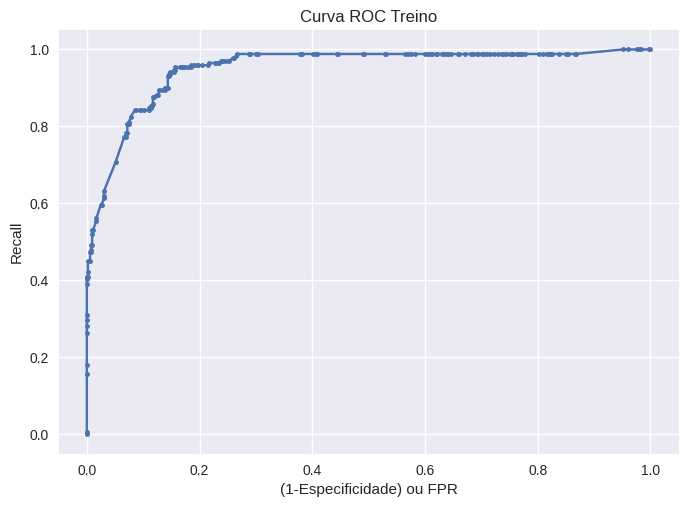

AUC ROC treino: 0.9512209951469726
Índice de Gini treino: 0.9024419902939451


In [ ]:
# Supõe-se que você tenha as predições do modelo e os rótulos verdadeiros
y_true = [0, 0, 1, 1]  # rótulos verdadeiros
y_pred = [0.1, 0.4, 0.35, 0.8]  # probabilidades previstas pelo modelo

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(output_train['flag_fraud'], output_train['prob_fraud'])

# Plotando a curva ROC
plt.plot(fpr, tpr, marker='.')
plt.xlabel('(1-Especificidade) ou FPR')
plt.ylabel('Recall')
plt.title('Curva ROC Treino')
plt.show()

# Calculando a AUC ROC
auc_roc = roc_auc_score(output_train['flag_fraud'], output_train['prob_fraud'])
print('AUC ROC treino:', auc_roc)

# Calculando o Gini
gini = 2 * auc_roc - 1
print('Índice de Gini treino:', gini)

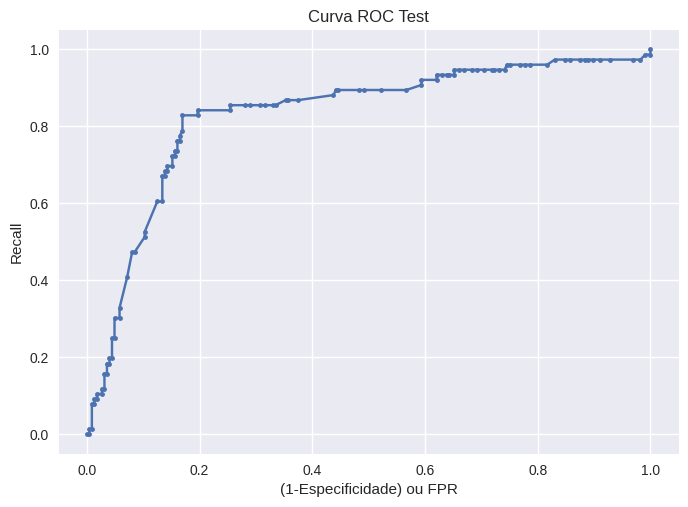

AUC ROC: 0.8308858082706767
Índice de Gini treino: 0.6617716165413534


In [ ]:
# Supõe-se que você tenha as predições do modelo e os rótulos verdadeiros
y_true = [0, 0, 1, 1]  # rótulos verdadeiros
y_pred = [0.1, 0.4, 0.35, 0.8]  # probabilidades previstas pelo modelo

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(output_test['flag_fraud'], output_test['prob_fraud'])

# Plotando a curva ROC
plt.plot(fpr, tpr, marker='.')
plt.xlabel('(1-Especificidade) ou FPR')
plt.ylabel('Recall')
plt.title('Curva ROC Test')
plt.show()

# Calculando a AUC ROC
auc_roc_test = roc_auc_score(output_test['flag_fraud'], output_test['prob_fraud'])
print('AUC ROC:', auc_roc_test)

# Calculando o Gini
gini_test = 2 * auc_roc_test - 1
print('Índice de Gini treino:', gini_test)

**Curva PR e AUC PR**

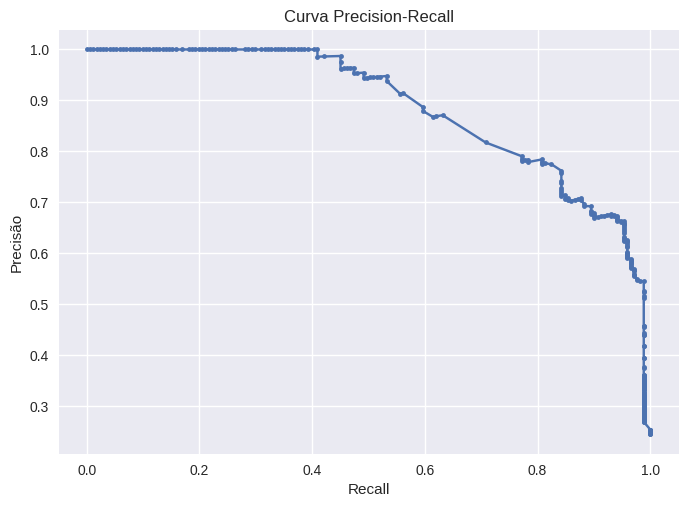

AUC PR: 0.8867183507626049


In [ ]:
# Calculando a curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(output_train['flag_fraud'], output_train['prob_fraud'])

# Plotando a curva PR
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.show()

# Calculando a AUC PR
auc_pr = auc(recall, precision)
print('AUC PR treino:', auc_pr)

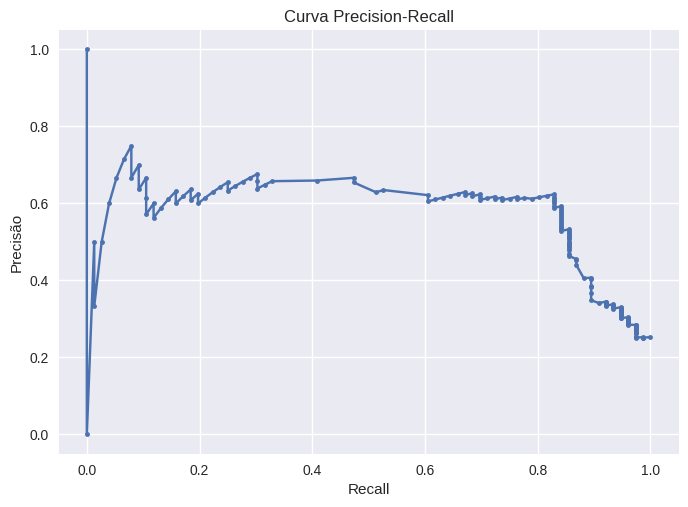

AUC PR treino: 0.5817291620719482


In [ ]:
# Calculando a curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(output_test['flag_fraud'], output_test['prob_fraud'])

# Plotando a curva PR
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.show()

# Calculando a AUC PR
auc_pr_test = auc(recall, precision)
print('AUC PR treino:', auc_pr_test)

## Interpretação de variáveis

**Importância**

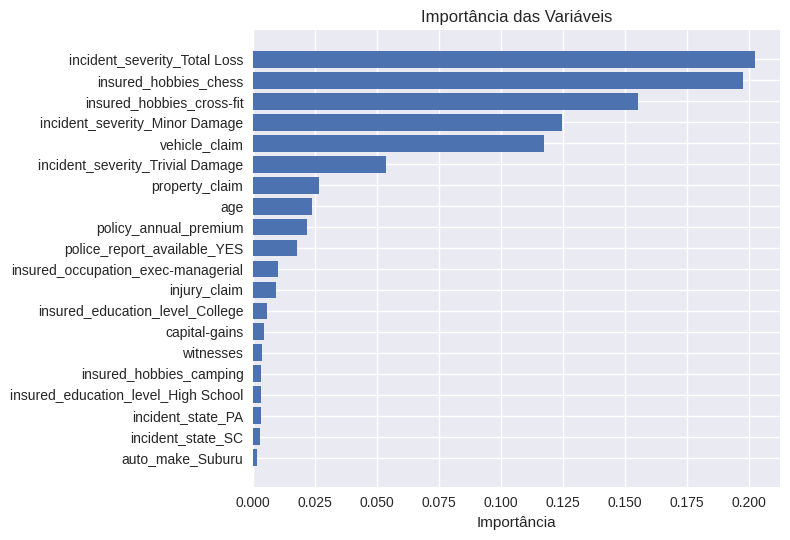

In [ ]:
# Obter as importâncias das variáveis
importances = best_model_optuna_cv.feature_importances_

# Ordenar as importâncias
indices = np.argsort(importances)[::-1]

# Exibir apenas as top 20 variáveis
top_indices = indices[:20]

# Plotar as importâncias
plt.title("Importância das Variáveis")
#plt.barh(range(X_train.shape[1]), importances[indices], align="center") #para exibir todas as variáveis
plt.barh(range(20), importances[top_indices], align="center")
#plt.yticks(range(X_train.shape[1]), X_train.columns[indices]) #para exibir todas as variáveis
plt.yticks(range(20), X_train.columns[top_indices])
plt.gca().invert_yaxis()
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

**SHAP**

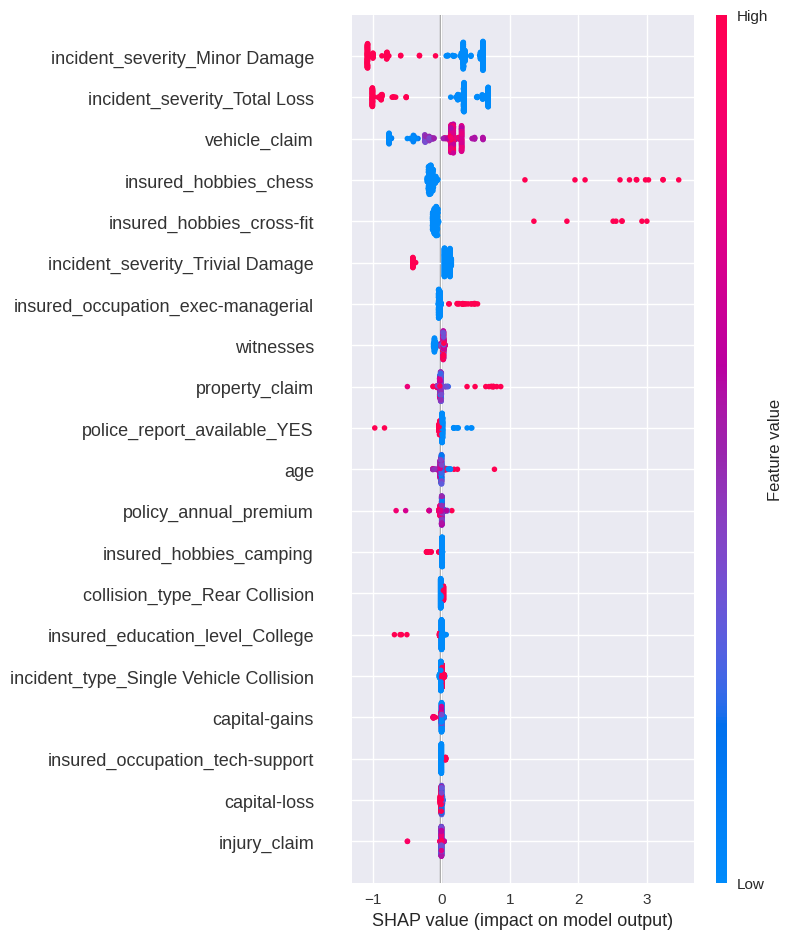

In [ ]:
# Criar o objeto explainer do SHAP
explainer = shap.TreeExplainer(best_model_optuna_cv)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Visualização dos valores SHAP
# O summary_plot mostra a importância global das features
shap.summary_plot(shap_values, X_test)

**Lime**

In [ ]:
# Criar um explicador LIME
explainer = lime_tabular.LimeTabularExplainer(X_train.values,
                                              feature_names=X_train.columns,
                                              class_names=['Non fraud','Fraud'],
                                              mode='classification')

In [ ]:
#Escolher uma instância do conjunto de teste para explicar
explanation = explainer.explain_instance(X_test.values[100],  # Observação a ser explicada
                                         best_model_optuna_cv.predict_proba,  # O modelo treinado com a função que retorna a probabilidade
                                         num_features=10  # Número de variáveis explicadas
)
explanation.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


## Estabilidade

In [ ]:
#estabilidade da volumetria
Gains_Table_train['perc_tot_treino'] = Gains_Table_train['qt_tot']/Gains_Table_train['qt_tot'].sum()
Gains_Table_train['rate_treino'] = Gains_Table_train['rate_1']
Gains_Table_train['avg_prob_treino'] = Gains_Table_train['avg_prob1']

Gains_Table_test['perc_tot_test'] = Gains_Table_test['qt_tot']/Gains_Table_test['qt_tot'].sum()
Gains_Table_test['rate_test'] = Gains_Table_test['rate_1']
Gains_Table_test['avg_prob_test'] = Gains_Table_test['avg_prob1']

df_estabilidade = Gains_Table_train[['decile','perc_tot_treino','rate_treino','avg_prob_treino']].merge(Gains_Table_test[['decile','perc_tot_test','rate_test','avg_prob_test']], on='decile')


In [ ]:
def psi(expected, actual, epsilon=1e-10):
    expected = np.array(expected)
    actual = np.array(actual)

    # Substitui valores iguais a zero por um valor mínimo (epsilon) para evitar divisão por zero
    expected = np.where(expected == 0, epsilon, expected)
    actual = np.where(actual == 0, epsilon, actual)

    psi_value = np.sum((expected - actual) * np.log(expected / actual))
    return psi_value

**Volumetria**

In [ ]:
psi_volum = psi(df_estabilidade['perc_tot_treino'], df_estabilidade['perc_tot_test'])
psi_volum

0.06450500345815288

<ipython-input-133-57f1ed17e241>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


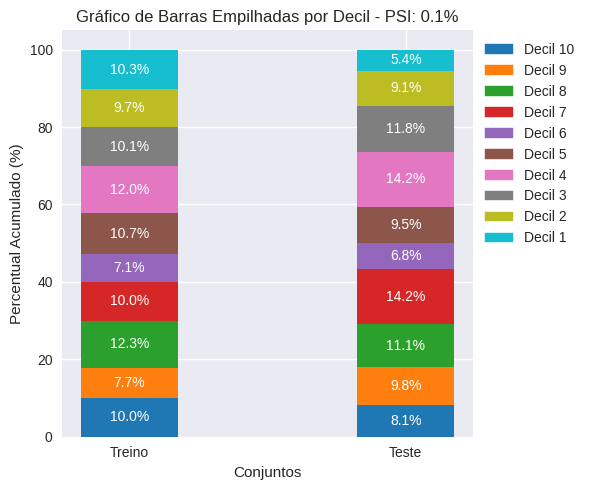

In [ ]:
# Organizar os dados para o gráfico
categories = ['Treino', 'Teste']
treino = df_estabilidade['perc_tot_treino'] * 100
teste = df_estabilidade['perc_tot_test'] * 100

# Definir a largura das barras
bar_width = 0.35

fig, ax = plt.subplots(figsize=(6, 5))

# Usar um colormap para ter cores consistentes para os decílios
colors = plt.cm.get_cmap('tab10', 10)

# Barras empilhadas para o treino
bottom_treino = np.zeros(len(treino))
bottom_teste = np.zeros(len(teste))

# Empilhar as barras e adicionar rótulos corretamente no centro de cada seção
for i in range(len(treino)):
    rects_treino = ax.bar(categories[0], treino[i], bar_width, bottom=bottom_treino, color=colors(i), label=f'Decil {deciles[i]}' if i == 0 else "")
    rects_teste = ax.bar(categories[1], teste[i], bar_width, bottom=bottom_teste, color=colors(i))

    # Adicionar rótulos de dados no centro da barra empilhada
    ax.text(categories[0], bottom_treino[0] + treino[i]/2, f'{treino[i]:.1f}%', ha='center', va='center', color='white')
    ax.text(categories[1], bottom_teste[0] + teste[i]/2, f'{teste[i]:.1f}%', ha='center', va='center', color='white')

    # Atualizar o valor acumulado da pilha
    bottom_treino += treino[i]
    bottom_teste += teste[i]

# Adicionar título e rótulos
plt.title(f'Gráfico de Barras Empilhadas por Decil - PSI: {psi_volum:.1f}%')
plt.ylabel('Percentual Acumulado (%)')
plt.xlabel('Conjuntos')

# Ajustar a legenda para exibir os decílios com as mesmas cores
handles = [plt.Rectangle((0, 0), 1, 1, color=colors(i)) for i in range(10)]
labels = [f'Decil {d}' for d in deciles]
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Probabilidade média**

In [ ]:
psi_prob = psi(df_estabilidade['avg_prob_treino'], df_estabilidade['avg_prob_test'])
psi_prob

0.002827447529000294

<ipython-input-140-bc0841de68dd>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot(categories, [treino[i], teste[i]], marker='o', label=f'Decil {deciles[i]}', color=plt.cm.get_cmap('tab10', 10)(i))


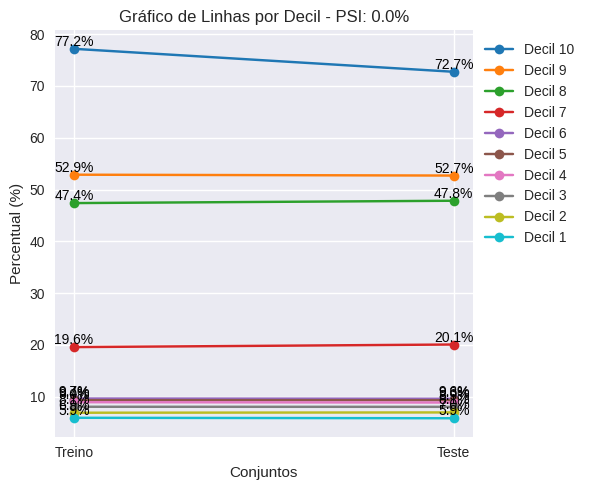

In [ ]:
# Organizar os dados para o gráfico
categories = ['Treino', 'Teste']
treino = df_estabilidade['avg_prob_treino'] * 100
teste = df_estabilidade['avg_prob_test'] * 100

# Organizar os dados para o gráfico
categories = ['Treino', 'Teste']
treino = df_estabilidade['avg_prob_treino'] * 100
teste = df_estabilidade['avg_prob_test'] * 100

# Criar o gráfico de linhas com treino e teste no eixo X
fig, ax = plt.subplots(figsize=(6, 5))

# Plotar linhas para cada decil
for i in range(len(deciles)):
    ax.plot(categories, [treino[i], teste[i]], marker='o', label=f'Decil {deciles[i]}', color=plt.cm.get_cmap('tab10', 10)(i))

# Adicionar rótulos de dados para treino e teste
for i in range(len(deciles)):
    ax.text(categories[0], treino[i], f'{treino[i]:.1f}%', ha='center', va='bottom', color='black')
    ax.text(categories[1], teste[i], f'{teste[i]:.1f}%', ha='center', va='bottom', color='black')

# Adicionar título e rótulos
plt.title(f'Gráfico de Linhas por Decil - PSI: {psi_prob:.1f}%')
plt.ylabel('Percentual (%)')
plt.xlabel('Conjuntos')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Taxa observada média**

In [ ]:
psi_rate = psi(df_estabilidade['rate_treino'], df_estabilidade['rate_test'])
psi_rate

601.293457069878

<ipython-input-148-1e1d411f785e>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot(categories, [treino[i], teste[i]], marker='o', label=f'Decil {deciles[i]}', color=plt.cm.get_cmap('tab10', 10)(i))


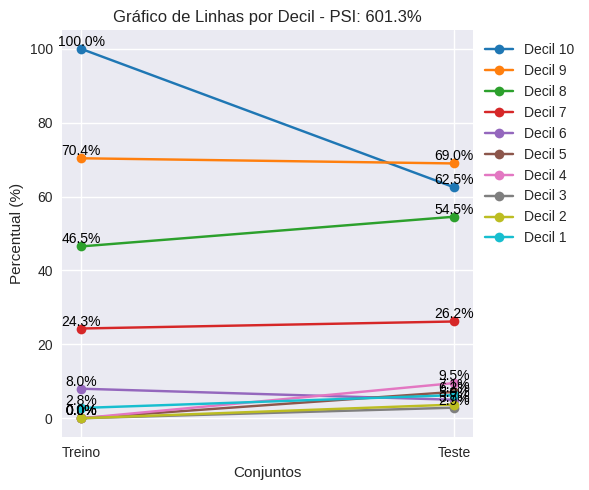

In [ ]:
# Organizar os dados para o gráfico
categories = ['Treino', 'Teste']
treino = df_estabilidade['rate_treino']
teste = df_estabilidade['rate_test']

# Criar o gráfico de linhas com treino e teste no eixo X
fig, ax = plt.subplots(figsize=(6, 5))

# Plotar linhas para cada decil
for i in range(len(deciles)):
    ax.plot(categories, [treino[i], teste[i]], marker='o', label=f'Decil {deciles[i]}', color=plt.cm.get_cmap('tab10', 10)(i))

# Adicionar rótulos de dados para treino e teste
for i in range(len(deciles)):
    ax.text(categories[0], treino[i], f'{treino[i]:.1f}%', ha='center', va='bottom', color='black')
    ax.text(categories[1], teste[i], f'{teste[i]:.1f}%', ha='center', va='bottom', color='black')

# Adicionar título e rótulos
plt.title(f'Gráfico de Linhas por Decil - PSI: {psi_rate:.1f}%')
plt.ylabel('Percentual (%)')
plt.xlabel('Conjuntos')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()